# LinearSVC trained with Word2Vec embeddings (RQ2)

In [1]:
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA

### Load the data

In [2]:
# Load the training data 
X_train = pd.read_csv("data/X_train.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_train = pd.read_csv("data/y_train.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the validation data 
X_val = pd.read_csv("data/X_val.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_val = pd.read_csv("data/y_val.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the test data 
X_test = pd.read_csv("data/X_test.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_test = pd.read_csv("data/y_test.csv", index_col=0).reset_index(drop=True)['Sentiment']

In [4]:
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

/Users/paula/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [5]:
# Load pretrained vectors from Google
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

### Create Word2Vec features
The `generate_feature_vectors` function:
1. initializes two empty lists: `features` and `y_new`.
2. iterates over each tweet in the `tweets` list, splitting it into individual words.
3. for each word in the tweet, check if it exists in the word2vec model's vocabulary, and if so, add the corresponding vector representation of the word is to the `vectors` list.
4. if the `vectors` list is not empty, this takes the average of all vectors in the list to generate one single feature vector for the tweet.
5. the feature vector is appended to the `features` list.
6. the corresponding y value for the tweet is appended to the `y_new` list.
8. if the vectors list is empty (i.e., no vectors were found for any words in the tweet), the function skips it and prints a message
9. after all tweets have been processed, two arrays are returned: `features` that contains all the generated feature vectors, and `y_new` that contains the corresponding y values for each tweet that had non-empty vectors lists.

The `features` is a 2D numpy array of shape `(num_tweets, vector_size)`, where num_tweets is the number of tweets in tweets, and `vector_size` is the dimensionality of the Word2Vec vectors (e.g., 100 or 300). Each row of the array corresponds to the feature vector for a single tweet.

In [6]:
# Function to generate feature vectors for tweets
def generate_feature_vectors(tweets, model, y):
    features = [] # list to store feature vectors
    y_new = [] # list to store corresponding labels
    for i, tweet in enumerate(tweets):
        words = tweet.split() # split the tweet into words
        vectors = [model[word] for word in words if word in model] # retrieve vectors for words present in the model
        if vectors:
            feature_vector = np.average(vectors, axis=0) # compute the avg. of the word vectors to create a feature vector for the tweet
            features.append(feature_vector) # append feature vector to the list of features
            y_new.append(y[i]) # append corresponding label to the list of labels
        else:
            print(f"Skipping tweet {i} as no vectors found.") # message if no vectors are found for the tweet
    return (np.array(features), np.array(y_new)) # convert the lists to arrays & return the feature vectors + labels

### PCA

In [7]:
# Generate feature vectors for the training set
X_train, y_train = generate_feature_vectors(X_train, w2v_model, y_train)

# Apply PCA to reduce the dimensionality of the feature space
pca = PCA(n_components=200)
X_train = pca.fit_transform(X_train)

# Generate feature vectors for the validation set
X_val, y_val = generate_feature_vectors(X_val, w2v_model, y_val)

# Apply PCA to reduce the dimensionality of the feature space
X_val = pca.transform(X_val)

# Generate feature vectors for the test set
X_test, y_test = generate_feature_vectors(X_test, w2v_model, y_test)

# Apply PCA to reduce the dimensionality of the feature space
X_test = pca.transform(X_test)

Skipping tweet 3995 as no vectors found.
Skipping tweet 5434 as no vectors found.
Skipping tweet 14128 as no vectors found.
Skipping tweet 17050 as no vectors found.
Skipping tweet 24472 as no vectors found.
Skipping tweet 25876 as no vectors found.
Skipping tweet 27371 as no vectors found.


### LinearSVC Hyperparameter tuning
The `GridSearchCV` function performs a grid search with 5-fold cross-validation to find the best hyperparameters. 

In [8]:
# Define the parameter grid to search over
param_grid = {'C': [0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 1.25, 1.5, 2],     
              'class_weight': [None, 'balanced']}

# Perform grid search with cross-validation
grid_search = GridSearchCV(LinearSVC(), param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_svc = grid_search.best_estimator_

# Predict labels for the validation set
y_val_pred = best_svc.predict(X_val)

# Print the classification report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1395
           1       0.55      0.59      0.57       727
           2       0.75      0.72      0.74      1674

    accuracy                           0.70      3796
   macro avg       0.67      0.68      0.67      3796
weighted avg       0.70      0.70      0.70      3796



In [9]:
# Print the best hyperparameters and the corresponding F1 score
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best hyperparameters: {'C': 0.25, 'class_weight': 'balanced'}
Best F1 score: 0.6653820881927623


### Train LinearSVC with best hyperparameters

After selecting the best hyperparameters using the validation set, the model will be trained on the entire training set which includes both the original training data and the validation data. Once the model is trained, it will be evaluated on the test set to assess its performance.

In [10]:
# Merge X values
X_train_val = np.concatenate((X_train, X_val), axis=0)

# Merge y values
y_train_val = np.concatenate([y_train, y_val], axis=0)

In [11]:
# Fit the model with best hyperparameters on the merged data
svc = LinearSVC(C=0.25, class_weight='balanced', max_iter=10000, tol=1e-3)
svc.fit(X_train_val, y_train_val)

# Evaluate the performance of the pipeline on the test set
y_test_pred = svc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy score: {:.2f}%".format(accuracy * 100))

# Calculate precision, recall, f1-score and support for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Print the classification report
print("Classification report:\n")
print("Class\tPrecision\tRecall\t\tF1-score\tSupport")
print("-" * 55)
for i in range(len(precision)):
    print("{}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{}".format(i, precision[i], recall[i], f1[i], support[i]))
print("-" * 55)


Accuracy score: 68.20%
Classification report:

Class	Precision	Recall		F1-score	Support
-------------------------------------------------------
0	0.73		0.71		0.72		1633
1	0.49		0.61		0.55		617
2	0.73		0.68		0.70		1546
-------------------------------------------------------


In [12]:
# print the classification report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1633
           1       0.49      0.61      0.55       617
           2       0.73      0.68      0.70      1546

    accuracy                           0.68      3796
   macro avg       0.65      0.67      0.66      3796
weighted avg       0.69      0.68      0.69      3796



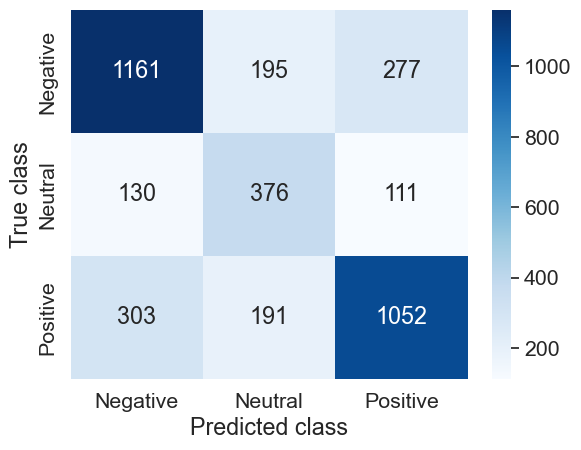

In [13]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1, 2])

# Plot the confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

In [14]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)
    
    # Weighted Metrics
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Recall:", weighted_recall)
    print("Weighted Precision:", weighted_precision)
    print("Weighted F1 Score:", weighted_f1)


In [15]:
evaluate_model(svc, X_test, y_test)

Confusion Matrix:
[[1161  195  277]
 [ 130  376  111]
 [ 303  191 1052]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1633
           1       0.49      0.61      0.55       617
           2       0.73      0.68      0.70      1546

    accuracy                           0.68      3796
   macro avg       0.65      0.67      0.66      3796
weighted avg       0.69      0.68      0.69      3796

Weighted Recall: 0.6820337197049526
Weighted Precision: 0.691068553628193
Weighted F1 Score: 0.6851528835381269


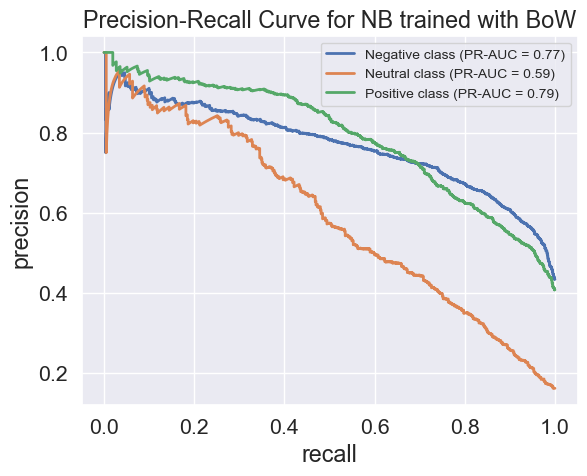

In [16]:
n_classes = 3

# perform one-hot encoding on target variable
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# predict decision scores
decision_scores = svc.decision_function(X_test)

# calculate precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()

class_names = [(0,'Negative'),(1,'Neutral'), (2,'Positive')]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], decision_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], decision_scores[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{} class (PR-AUC = {:.2f})'.format(class_names[i][1], average_precision[i]))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best",fontsize=10)
plt.title("Precision-Recall Curve for NB trained with BoW")
plt.show()


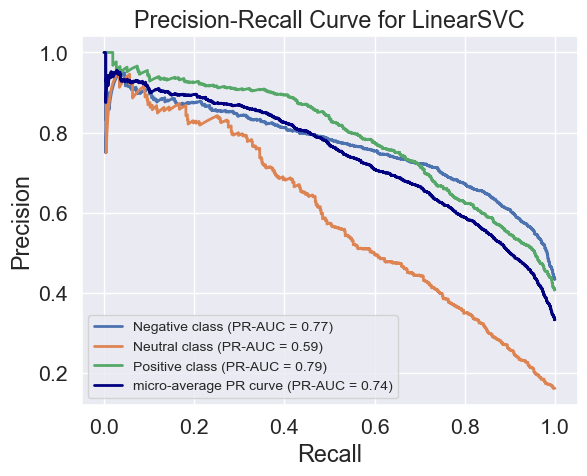

In [17]:
# Precision-Recall curve with Micro averaging for multiclass classification
from sklearn.preprocessing import LabelBinarizer

# perform one-hot encoding on target variable
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# predict scores
y_score = svc.decision_function(X_test)

# calculate precision and recall for each class using one-vs-all approach
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{} class (PR-AUC = {:.2f})'.format(class_names[i][1], average_precision[i]))
    
# calculate micro-averaged precision and recall
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision_micro = average_precision_score(y_test_bin, y_score, average='micro')

# plot overall micro-averaged precision-recall curve
plt.plot(recall_micro, precision_micro, color='navy', lw=2,
         label='micro-average PR curve (PR-AUC = {0:0.2f})'
               ''.format(average_precision_micro))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best", fontsize=10)
plt.title('Precision-Recall Curve for LinearSVC')
plt.show()


This plots only the micro-average curve in the Precision-Recall plot. The micro-average curve is a weighted average of precision and recall computed over all classes, and is often used in multiclass classification problems.

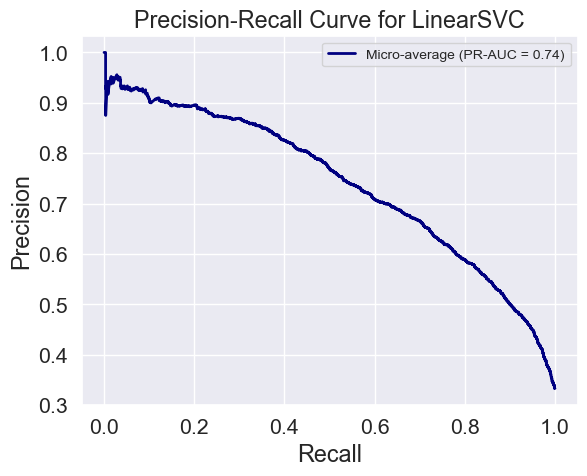

In [18]:
# Convert y_test to binary label matrix
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# predict probabilities
y_score = svc.decision_function(X_test)

# Calculate precision and recall using micro averaging
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())

# Calculate average precision score using micro averaging
average_precision_micro = average_precision_score(y_test_bin, y_score, average='micro')

# Plot micro-average curve
plt.plot(recall_micro, precision_micro, color='navy', lw=2,
         label='Micro-average (PR-AUC = {0:0.2f})'.format(average_precision_micro))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best', fontsize=10)
plt.title('Precision-Recall Curve for LinearSVC')
plt.show()


#### Save Precision-Recall Curve

In [19]:
#np.save('Precision-Recall Curves/precision_micro_w2vec.npy', precision_micro)
#np.save('Precision-Recall Curves/recall_micro_w2vec.npy', recall_micro)

In [23]:
# load the array from file
#precision_micro_w2vec = np.load('Precision-Recall Curves/precision_micro_w2vec.npy')
#recall_micro_w2vec = np.load('Precision-Recall Curves/recall_micro_w2vec.npy')